In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score)
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
df_data = pd.read_csv('dados_limpos.csv')
df_data.head()

,team_a,team_b,map,team_a_wins,team_a_avg_rating,team_a_avg_acs,team_a_avg_kast,team_a_avg_adr,team_a_avg_hs,team_a_avg_fk,...,ratio_total_games,diff_rating_consistency,ratio_rating_consistency,diff_acs_consistency,ratio_acs_consistency,team_a_map_wr,team_b_map_wr,team_a_map_games,team_b_map_games,diff_map_wr
0,Akrew,BASILISK,Bind,1,6.011543,1142.131429,4.040857,747.531429,1.259886,11.765714,...,0.697208,0.008985,1.002706,0.084473,1.025624,0.733333,0.526316,30,38,0.207018
1,Akrew,BASILISK,Split,1,6.011543,1142.131429,4.040857,747.531429,1.259886,11.765714,...,0.697208,0.008985,1.002706,0.084473,1.025624,0.850000,0.434783,20,23,0.415217
2,BASILISK,Akrew,Bind,0,5.291952,1082.501992,3.772550,699.035857,1.355618,11.063745,...,1.434278,-0.008985,0.996627,-0.084473,0.974425,0.526316,0.733333,38,30,-0.207018
3,BASILISK,Akrew,Split,0,5.291952,1082.501992,3.772550,699.035857,1.355618,11.063745,...,1.434278,-0.008985,0.996627,-0.084473,0.974425,0.434783,0.850000,23,20,-0.415217
4,Akrew,Built By Gamers Academy,Haven,1,6.011543,1142.131429,4.040857,747.531429,1.259886,11.765714,...,0.940855,-0.067576,0.977351,-0.562985,0.855576,0.720930,0.555556,43,36,0.165375


In [79]:
df_data.shape

(2422, 57)

In [82]:
# Preparar features para modelagem
le_map = LabelEncoder()
df_data['map_encoded'] = le_map.fit_transform(df_data['map'])

# Selecionar features numéricas para o modelo
feature_columns = [col for col in df_data.columns 
                  if col.startswith(('team_a_', 'team_b_', 'diff_', 'ratio_', 'map_encoded')) 
                  and not col.endswith('_wins')]

X = df_data[feature_columns]
y = df_data['team_a_wins']

print(f"\nFeatures selecionadas: {len(feature_columns)}")

# Tratar valores infinitos e NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizar features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")


Features selecionadas: 54
Tamanho do conjunto de treino: (1937, 54)
Tamanho do conjunto de teste: (485, 54)



=== TREINANDO E AVALIANDO MODELOS ===

--- Random Forest ---
Acurácia: 0.5814
Precisão: 0.5844
Recall: 0.5579
F1-Score: 0.5708
AUC-ROC: 0.6144
CV Accuracy: 0.5715 (±0.0336)


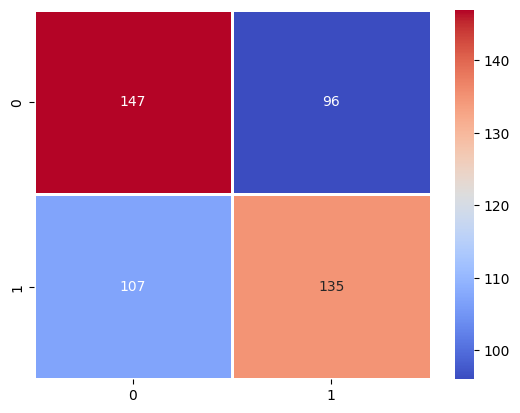


--- Gradient Boosting ---
Acurácia: 0.5711
Precisão: 0.5746
Recall: 0.5413
F1-Score: 0.5574
AUC-ROC: 0.5988
CV Accuracy: 0.5524 (±0.0463)


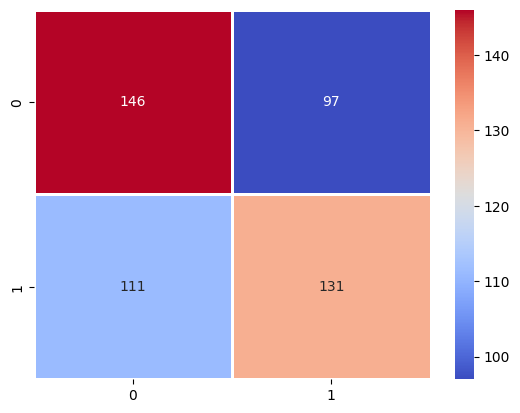


--- Logistic Regression ---
Acurácia: 0.6474
Precisão: 0.6621
Recall: 0.5992
F1-Score: 0.6291
AUC-ROC: 0.6948
CV Accuracy: 0.6231 (±0.0564)


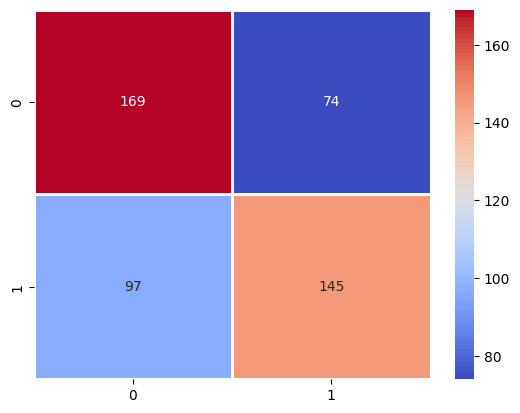

In [83]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

results = {}

print("\n=== TREINANDO E AVALIANDO MODELOS ===")

for name, model in models.items():
    print(f"\n--- {name} ---")
    
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }
    
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")
    sns.heatmap(confusion_matrix(y_test, y_pred), cmap='coolwarm', annot=True, linewidth=1, fmt='d')
    plt.show()